In [40]:
#imports
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import yfinance as yf
yf.pdr_override() #needed to correct pdr format 

[*********************100%%**********************]  1 of 1 completed


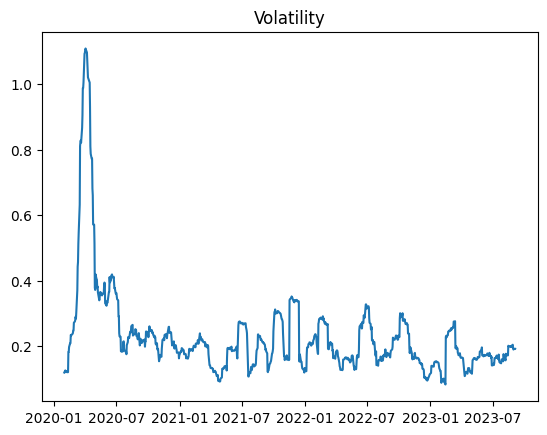

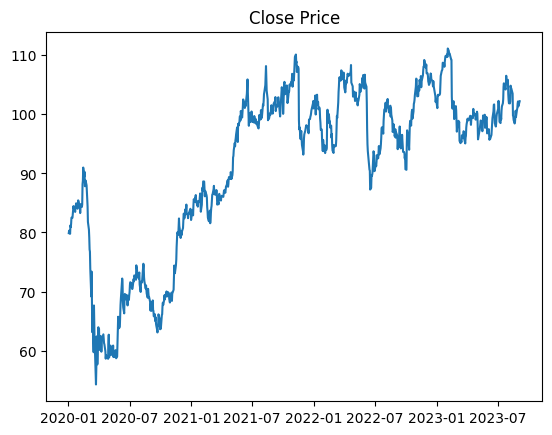

In [49]:
end = dt.datetime.now()
start = dt.datetime(2020,1,1)
df = pdr.get_data_yahoo(['CBA.AX'], start, end)
Close = df.Close
Close.tail()
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
TRADING_DAYS = 20

volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
plt.plot(volatility)
plt.title("Volatility")
plt.show()

plt.plot(Close)
plt.title("Close Price")
plt.show()


In [42]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta
def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess 
    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break
        vol_old = vol_new
    implied_vol = vol_new
    return implied_vol

In [43]:
S0 = 102
atm_options = [
[dt.date(2021,10,18),102,[2.585,3.25],[4.600,5.300]],
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []
for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3] 
    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)
call_bids,call_asks,put_bids,put_asks

([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

In [44]:
K = 102
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

In [45]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)
        
def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan
def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan
        
def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

In [46]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'
call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300
# number of sims
M = 1000
# Realized Volatility
sigma = 0.12
# Position in Option contract
k = 102
position = 's'
flag = 'c'

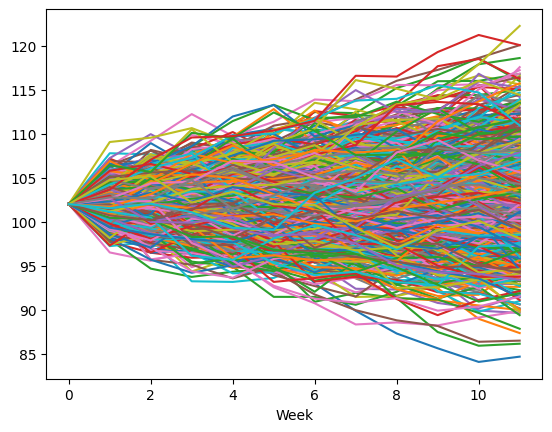

,Time,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,102.00,102.45,103.86,103.55,100.56,99.04,101.56,100.41,103.10,...,102.30,101.67,100.45,103.67,102.63,100.73,102.63,102.77,104.75,101.54
2,0.18,102.15,101.68,101.30,101.44,101.77,100.34,101.79,101.80,105.39,...,103.28,103.15,100.26,107.05,99.98,100.17,104.37,102.65,105.17,102.06
3,0.16,103.31,99.90,99.56,101.96,102.49,100.59,100.47,101.70,102.29,...,102.27,105.41,98.27,109.58,99.90,101.49,104.56,104.73,102.19,101.07
4,0.14,98.33,98.86,98.01,101.33,105.88,101.13,97.79,105.12,102.09,...,103.94,104.97,98.31,109.74,100.56,101.96,106.93,101.49,103.41,99.32
5,0.12,98.68,97.37,99.48,98.97,105.12,102.50,101.33,105.70,105.69,...,103.34,103.14,96.81,110.38,98.48,99.97,106.78,102.99,101.99,99.07
6,0.10,92.97,97.06,100.50,96.76,106.29,104.54,101.08,105.02,107.74,...,102.95,101.35,96.39,111.48,98.58,101.24,105.04,104.65,101.91,103.30
7,0.08,89.87,95.62,97.13,100.74,108.28,105.85,98.61,105.63,108.60,...,98.76,100.04,96.34,116.60,97.56,100.29,103.40,104.63,99.30,104.95
8,0.06,87.29,96.26,96.99,99.87,107.36,104.33,96.64,107.78,106.73,...,100.21,101.46,94.81,116.51,95.02,101.21,107.88,104.45,97.04,107.12


In [47]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)
no_hedge = []
static_hedge = []
# number of sims
St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)
    
St_series = np.array(St_series)
df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df

In [48]:
for sim in range(M):
    hedgeSim = df.loc[:,['Time',sim]]
    hedgeSim.columns = ['Time', 'Price']
    
    # hedge calcs
    hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'], K, x['Time'], r, sigma, position), axis=1)
    hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
    totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Contracts'] = hedgeSim.apply(lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
    hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],x['Time']), axis=1)
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(lambda x: cashAdj(x['Total Delta Position'],x['Price'],x['Time'], x['totaladjust_c']), axis=1)
    hedgeSim['Interest on Adjustments'] = hedgeSim.apply(lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2), axis=1)
    hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])
    
    # calculate payoffs
    if flag == 'c':
        if position == 's':
            optprice = call_bid
            option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
            # delta will be negative if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be negative if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = call_ask
            option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
            # delta will be positive if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be positive if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
            
    elif flag == 'p':
        if position == 's':
            optprice = put_bid
            option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
            # delta will be positive if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be positive if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = put_ask
            option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
            # delta will be negative if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be negative if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        
    data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]
    #add to dataframe
    Dynamic_sim = pd.DataFrame(data=data, columns=[sim], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
    Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
    no_hedge.append(option_pnl+option_carry)
    static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)
hedgeSim

C:\Users\mabon\AppData\Local\Temp\ipykernel_3976\2000409840.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\mabon\AppData\Local\Temp\ipykernel_3976\2000409840.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
C:\Users\mabon\AppData\Local\Temp\ipykernel_3976\2000409840.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,Time,Price,delta,Total Delta Position,Adjustment Contracts,Total Adjustment,Adjustment Cashflow,Interest on Adjustments
Week,,,,,,,,
0,0.22,102.00,-54.0,NaN,NaN,NaN,NaN,NaN
1,0.20,101.54,-50.0,4.0,Sell 4.0,Short 4.0,406.16,1.62
2,0.18,102.06,-54.0,-4.0,Buy 4.0,NaN,-408.24,-1.47
3,0.16,101.07,-46.0,8.0,Sell 8.0,Short 8.0,808.56,2.59
4,0.14,99.32,-30.0,16.0,Sell 16.0,Short 24.0,1589.12,4.45
5,0.12,99.07,-26.0,4.0,Sell 4.0,Short 28.0,396.28,0.95
6,0.10,103.30,-65.0,-39.0,Buy 39.0,Long 11.0,-4028.70,-8.06
7,0.08,104.95,-81.0,-16.0,Buy 16.0,Long 27.0,-1679.20,-2.69
8,0.06,107.12,-95.0,-14.0,Buy 14.0,Long 41.0,-1499.68,-1.80


In [ ]:
Dynamic_Hedging_Results.loc['TOTAL CASHFLOW'] = Dynamic_Hedging_Results.sum(axis=0)
Dynamic_Hedging_Results

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Dynamic hedging results,,,,,,,,,,,,,,,,,,,,,
Original Option P&L,157.500000,258.500000,158.500000,-683.500000,258.500000,258.500000,258.500000,222.500000,-369.500000,-217.500000,...,258.500000,258.500000,20.500000,29.500000,152.500000,258.500000,258.500000,258.500000,258.500000,9.500000
Original Stock P&L,54.540000,-93.420000,54.000000,508.680000,-182.520000,-331.020000,-151.200000,19.440000,339.120000,257.040000,...,-193.860000,-69.660000,128.520000,123.660000,57.240000,-130.680000,-99.360000,-329.940000,-168.480000,134.460000
Adjustment P&L,-111.230000,-153.680000,-121.090000,248.090000,-99.950000,74.770000,-188.350000,-292.460000,92.920000,59.340000,...,-26.820000,-178.860000,-52.250000,-111.300000,-60.040000,-313.250000,-163.660000,113.530000,8.330000,-144.360000
Carry (interest) on options,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,...,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151
Carry (interest) on stock,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,...,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658
Interest on Adjustments,-11.220000,0.620000,-5.850000,-12.380000,9.090000,7.570000,11.230000,1.550000,-5.120000,-2.490000,...,14.260000,-9.460000,-5.900000,-13.580000,2.460000,-0.710000,12.750000,15.550000,6.870000,-9.340000
TOTAL CASHFLOW,66.578493,-10.991507,62.548493,37.878493,-37.891507,-13.191507,-92.831507,-71.981507,34.408493,73.378493,...,29.068493,-22.491507,67.858493,5.268493,129.148493,-209.151507,-14.781507,34.628493,82.208493,-32.751507


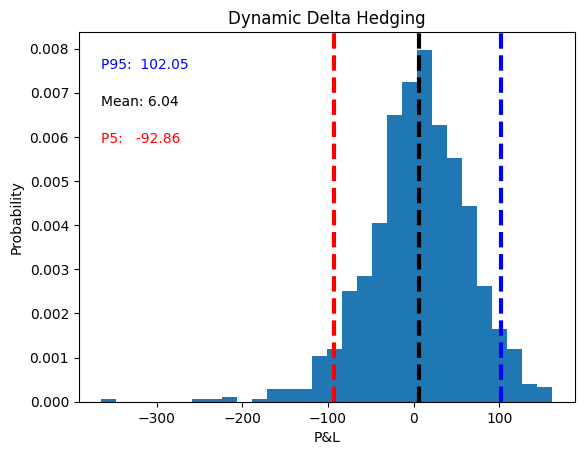

In [ ]:
x = Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

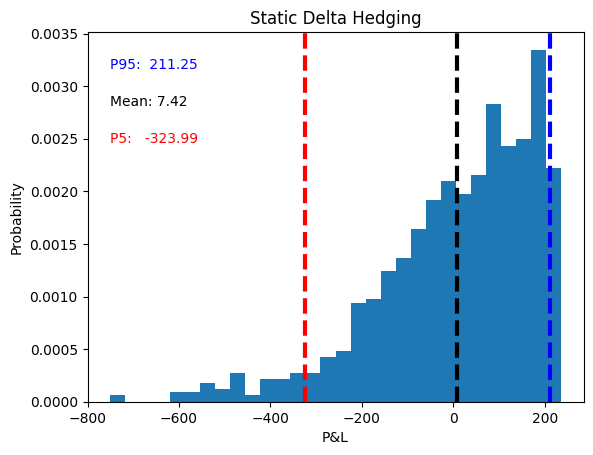

In [ ]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

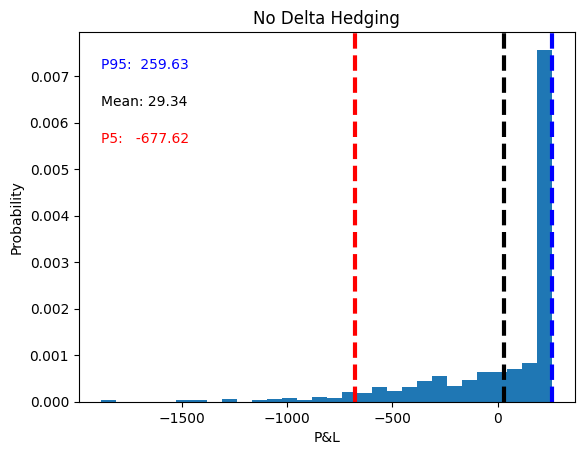

In [ ]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')